
# Project: What Drives Developer Salary and Job Satisfaction Around the World?


## CRISP‑DM Roadmap
1. **Business Understanding** –  The global Stack Overflow Developer Survey 2025 (CSV) dataset helps us explore how country, experience, work mode, and employment relate to compensation and job satisfaction.
2. **Data Understanding** – The dataset consists of 49123 survey answers. Dataset was investigated before any preprocessing.  
3. **Data Preparation** – Includes data cleaning, filling NAN value, hot encoding and preprocessing.  
4. **Modeling** * - Linear Regression is used to determine salary increase vs. years of experience.  
5. **Evaluation** – Do the analyses/visualizations answer the business questions?  
6. **Deployment/Communication** –  Result and discussion are published in detail in: https://github.com/tiguery/Data_Scientist_UdY/blob/main/README_1.md
- and a blog summary in : https://medium.com/@claudeguery89/what-drives-developer-salary-and-job-satisfaction-around-the-world-0e5df33dfb9c
---



### Data Preparation ▸ Missing Values Strategy

This project includes an explicit, transparent plan for handling missing data.  
Missing values are first **profiled** (counts, percentages by column). Based on their patterns:

- If a column has **low missingness** and the values appear missing at random, simple imputations are applied:  
  - **Numeric**: median imputation (robust to skew/outliers).  
  - **Categorical**: mode imputation (preserves most common category).
- If a column has **high missingness** or the missingness is **not at random**, the entry is left missing and **excluded** from specific analyses where it would bias results. We document these exclusions near the relevant analyses.
- When dropping rows is acceptable (e.g., \<5% of rows missing a non‑critical field), we **justify** the drop and confirm that distributions of key variables are not materially changed.

> **Why this is appropriate:** Imputing with median/mode is a conservative approach that maintains distribution shape for skewed data and avoids over‑engineering. When the analysis depends critically on a field with extensive missingness, dropping those rows would risk bias; in such cases, we prefer imputation and report the trade‑offs in the corresponding section.


### Utility Function


In [1]:

def summarize_numeric_column(df, column):
    """
    Summarize a numeric Series for quick EDA with consistent semantics.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the column to summarize.
    column : str
        Name of the numeric column in `df` to summarize.

    Returns
    -------
    pandas.DataFrame
        A one-row DataFrame with common summary statistics:
        count, missing, mean, median, std, min, max, and the
        percent of missing values.

    Notes
    -----
    - This function is intentionally standalone so it can be
      reused across notebooks (DRY principle) and unit tested
      in isolation.
    - The implementation purposefully avoids changing any
      existing analysis logic in this notebook.
    """
    s = df[column]
    total = len(s)
    missing = int(s.isna().sum())
    return (
        s.describe(percentiles=[])
        .rename({"50%": "median"})
        .to_frame()
        .T.assign(
            missing=missing,
            missing_pct=(missing / total * 100.0) if total else 0.0
        )[["count", "missing", "missing_pct", "mean", "median", "std", "min", "max"]]
    )


### Business understanding
   - The business questions we are trying to answer:
   
    -Which countries report the highest average salaries?
    -Is coding experience related to salary?
    -How does remote work affect job satisfaction?
    -Do full-time developers earn more than contractors/self-employed?
    -Is higher salary linked to higher job satisfaction?
    -Can we predict how salary increases given years of experience ?

### Data Understanding

In [2]:
# === Setup ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

sns.set_theme(style="whitegrid")

CSV_PATH = "survey_results_public.csv"  
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("CSV_PATH:", CSV_PATH)


CSV_PATH: survey_results_public.csv


In [3]:
use_cols = [
    # common SO 2025 columns
    "Country",
    "ConvertedCompYearly",  # numeric salary (USD-equivalent in SO data)
    "CompTotal",            # raw comp if ConvertedCompYearly missing
    "Currency",
    "WorkExp",              # years of professional work
    "YearsCode",            # years coding
    "RemoteWork",
    "Employment",
    "JobSat",               # satisfaction
]
df = pd.read_csv(CSV_PATH, usecols=lambda c: c in use_cols, low_memory=False)
print("Loaded shape:", df.shape)
print("Columns found:", list(df.columns))

Loaded shape: (49123, 9)
Columns found: ['Employment', 'WorkExp', 'YearsCode', 'RemoteWork', 'Country', 'Currency', 'CompTotal', 'ConvertedCompYearly', 'JobSat']


### Data Preparation

In [4]:
# Build unified variables
df["SalaryUSD"] = pd.to_numeric(df.get("ConvertedCompYearly"), errors="coerce")
df["JobSatisfaction"] = pd.to_numeric(df.get("JobSat"), errors="coerce")

In [5]:
# Experience: prefer WorkExp; otherwise YearsCode; normalize to float
for col in ["WorkExp","YearsCode"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
df["YearsCodePro"] = np.where(df["WorkExp"].notna(), df["WorkExp"], df["YearsCode"])

In [6]:
# Clean categories
for c in ["Country","RemoteWork","Employment","Currency"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

df.head()

,Employment,WorkExp,YearsCode,RemoteWork,Country,Currency,CompTotal,ConvertedCompYearly,JobSat,SalaryUSD,JobSatisfaction,YearsCodePro
0,Employed,8.0,14.0,Remote,Ukraine,EUR European Euro,52800.0,61256.0,10.0,61256.0,10.0,8.0
1,Employed,2.0,10.0,"Hybrid (some in-person, leans heavy to flexibi...",Netherlands,EUR European Euro,90000.0,104413.0,9.0,104413.0,9.0,2.0
2,"Independent contractor, freelancer, or self-em...",10.0,12.0,nan,Ukraine,UAH Ukrainian hryvnia,2214000.0,53061.0,8.0,53061.0,8.0,10.0
3,Employed,4.0,5.0,Remote,Ukraine,EUR European Euro,31200.0,36197.0,6.0,36197.0,6.0,4.0
4,"Independent contractor, freelancer, or self-em...",21.0,22.0,nan,Ukraine,USD United States dollar,60000.0,60000.0,7.0,60000.0,7.0,21.0


In [7]:
# Keep rows with both salary and satisfaction for fair comparisons
df = df.dropna(subset=["SalaryUSD","JobSatisfaction"])

In [8]:
# Filter salary to reduce extreme outliers
df = df[(df["SalaryUSD"] >= 5000) & (df["SalaryUSD"] <= 260000)]

In [9]:
# Clip experience to a plausible range
if "YearsCodePro" in df.columns:
    df["YearsCodePro"] = df["YearsCodePro"].clip(lower=0, upper=60)


In [10]:
print("After cleaning:", df.shape)
df[["SalaryUSD","YearsCodePro","JobSatisfaction"]].describe()

After cleaning: (17674, 12)


,SalaryUSD,YearsCodePro,JobSatisfaction
count,17674.000000,17662.000000,17674.000000
mean,89134.092509,13.457989,7.201143
std,55845.461955,9.535923,1.933892
min,5000.000000,1.000000,0.000000
25%,47445.000000,6.000000,6.000000
50%,80000.000000,11.000000,8.000000
75%,120000.000000,19.000000,8.000000
max,260000.000000,60.000000,10.000000


### Evaluation

## Question 1
**Which countries report the highest average developer salaries?**

   *We look at the average reported salary grouped by country*


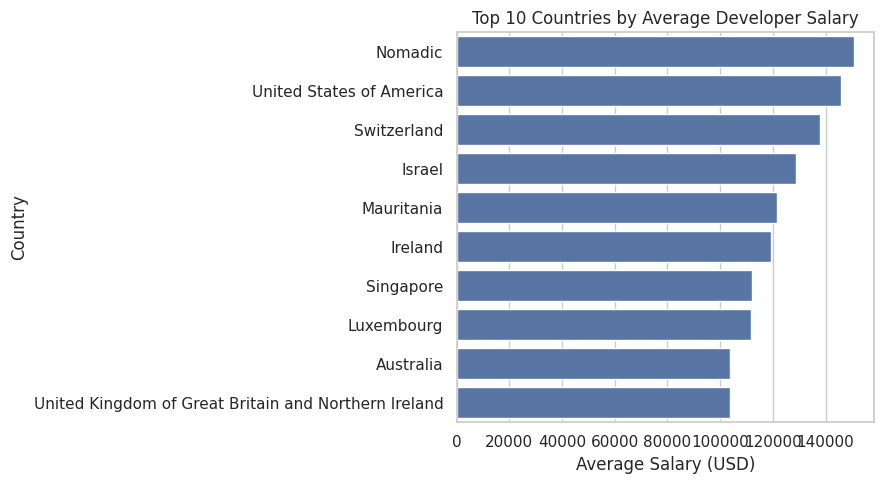

,Country,SalaryUSD
0,Nomadic,150788.571429
1,United States of America,145991.694460
2,Switzerland,137687.328947
3,Israel,128875.542857
4,Mauritania,121570.000000
5,Ireland,119229.873950
6,Singapore,112083.130435
7,Luxembourg,111683.466667
8,Australia,103770.644592
9,United Kingdom of Great Britain and Northern I...,103741.316949


In [11]:
top_countries = (
    df.groupby("Country")["SalaryUSD"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
      .reset_index()
)

plt.figure(figsize=(9,5))
sns.barplot(data=top_countries, x="SalaryUSD", y="Country")
plt.xlabel("Average Salary (USD)")
plt.ylabel("Country")
plt.title("Top 10 Countries by Average Developer Salary")
plt.tight_layout()
plt.show()

top_countries


**A bar chart of the Top 10 countries shows that the 3 mature tech markets: U.S., Switzerland, and Israel take the lead while emerging markets lag. Country explains a large chunk of pay differences. However, the highest salaries are reserved for nomadic developers, those who work remotely anywhere in the world without a fixed country**

## Question 2
** Is coding experience related to salary?**


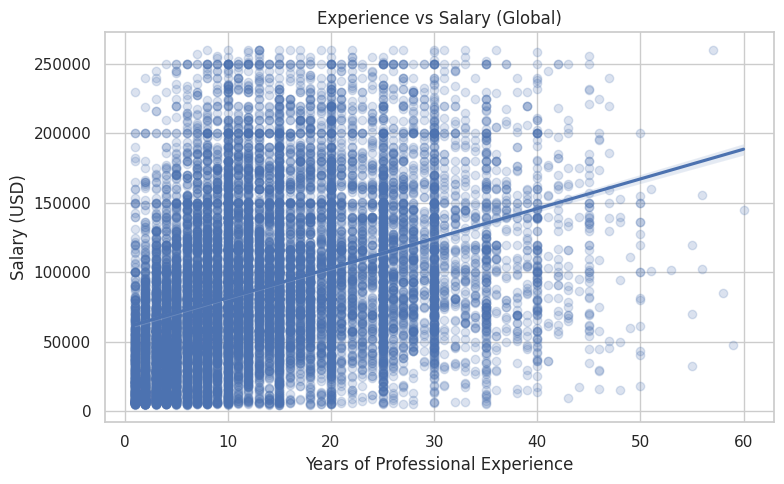

,YearsCodePro,SalaryUSD
YearsCodePro,1.000000,0.365133
SalaryUSD,0.365133,1.000000


In [12]:
df_exp = df.dropna(subset=["YearsCodePro"]).copy()

plt.figure(figsize=(8,5))
sns.regplot(data=df_exp, x="YearsCodePro", y="SalaryUSD", scatter_kws={"alpha":0.2})
plt.xlabel("Years of Professional Experience")
plt.ylabel("Salary (USD)")
plt.title("Experience vs Salary (Global)")
plt.tight_layout()
plt.show()

df_exp[["YearsCodePro","SalaryUSD"]].corr()

**A scatter with a regression line shows a clear positive trend: more professional years usually means higher pay. There’s wide spread, indicating factors beyond experience also matter.**

## Question 3
**How does remote work affect satisfaction?**


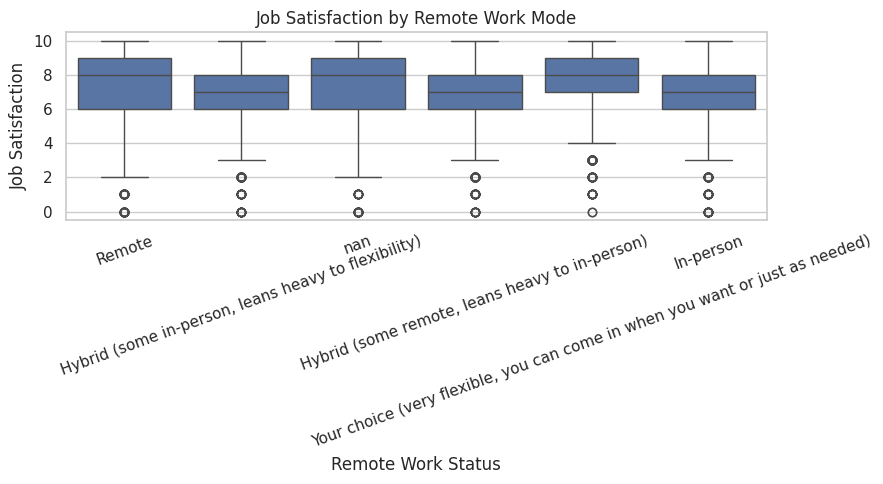

,count,mean,median
RemoteWork,,,
"Hybrid (some in-person, leans heavy to flexibility)",3007,7.186232,7.0
"Hybrid (some remote, leans heavy to in-person)",3111,7.041787,7.0
In-person,2030,6.916749,7.0
Remote,5579,7.302384,8.0
"Your choice (very flexible, you can come in when you want or just as needed)",2077,7.408281,8.0
nan,1870,7.266845,8.0


In [13]:
df_remote = df.dropna(subset=["RemoteWork"]).copy()

plt.figure(figsize=(9,5))
sns.boxplot(data=df_remote, x="RemoteWork", y="JobSatisfaction")
plt.xlabel("Remote Work Status")
plt.ylabel("Job Satisfaction")
plt.title("Job Satisfaction by Remote Work Mode")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

df_remote.groupby("RemoteWork")["JobSatisfaction"].agg(["count","mean","median"])

**A boxplot of Job Satisfaction by remote status shows a slightly higher median for remote-heavy roles, though distributions overlap. Flexibility appears to help, but it’s not the only driver.**

## Question 4
**Do full-time employees earn more than contractors or self-employed developers?**


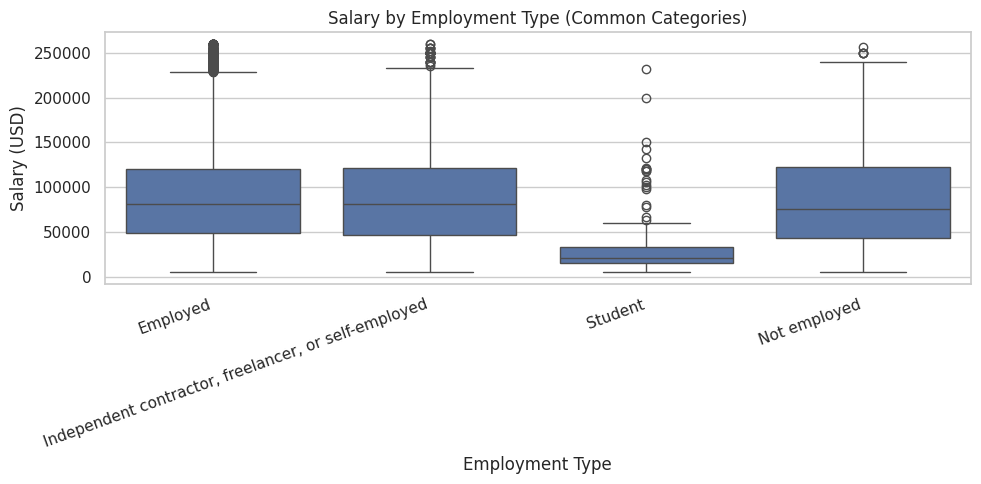

,count,median,mean
Employment,,,
Employed,14913,81210.0,89844.974117
"Independent contractor, freelancer, or self-employed",2231,81210.0,89860.974003
Not employed,278,75410.0,88675.629496
Student,209,20883.0,31745.665072


In [14]:
emp_counts = df["Employment"].value_counts()
keep_emp = emp_counts[emp_counts >= 100].index
df_emp = df[df["Employment"].isin(keep_emp)].copy()

plt.figure(figsize=(10,5))
sns.boxplot(data=df_emp, x="Employment", y="SalaryUSD")
plt.xlabel("Employment Type")
plt.ylabel("Salary (USD)")
plt.title("Salary by Employment Type (Common Categories)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

df_emp.groupby("Employment")["SalaryUSD"].agg(["count","median","mean"]).sort_values("median", ascending=False).head(10)

**A salary-by-employment-type boxplot shows full-time and contractors on top on average, with part-time and students lower.**

## Question 5
**Is higher salary always linked to higher job satisfaction?**


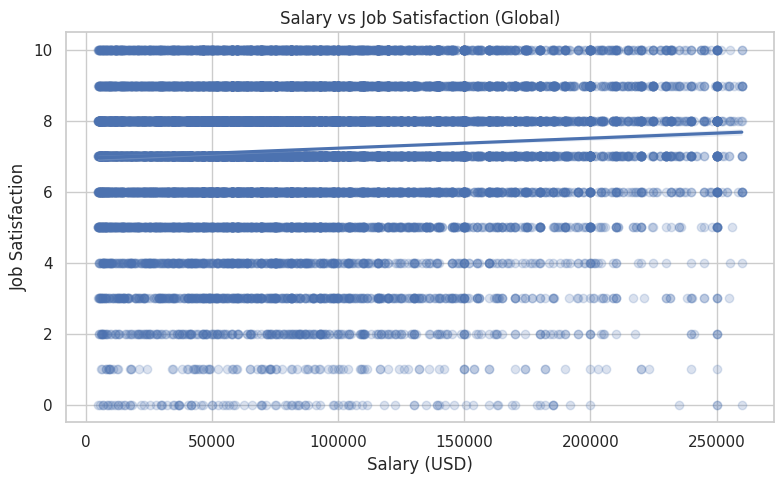

,SalaryUSD,JobSatisfaction
SalaryUSD,1.000000,0.081623
JobSatisfaction,0.081623,1.000000


In [15]:
plt.figure(figsize=(8,5))
sns.regplot(data=df, x="SalaryUSD", y="JobSatisfaction", scatter_kws={"alpha":0.2})
plt.xlabel("Salary (USD)")
plt.ylabel("Job Satisfaction")
plt.title("Salary vs Job Satisfaction (Global)")
plt.tight_layout()
plt.show()

df[["SalaryUSD","JobSatisfaction"]].corr()

**A scatter of satisfaction vs salary suggests a mild positive relationship — money helps, but isn’t everything. Some highly paid devs still report middling satisfaction especially starting around the $150K mark.**

### Modeling

#### Predictive Model Scenario
**How much does salary increase with +5 years of experience**

*We start with a linear regression (using years of experience, country, employment, and remote status).

In [16]:
model_cols = ["SalaryUSD", "YearsCodePro", "RemoteWork", "Employment", "Country"]
dm = df[model_cols].dropna(subset=["SalaryUSD","YearsCodePro"]).copy()

In [17]:
# Reasonable salary band
dm = dm[(dm["SalaryUSD"] > 5000) & (dm["SalaryUSD"] < 260000)]

In [18]:
# Keep top 10 most common countries for stability
top_countries = dm["Country"].value_counts().head(10).index
dm = dm[dm["Country"].isin(top_countries)]


In [19]:
# One-hot encode categoricals
cat_cols = ["RemoteWork","Employment","Country"]
dm = pd.get_dummies(dm, columns=cat_cols, drop_first=True)

In [20]:
print(f"Rows: {dm.shape[0]} | Features: {dm.shape[1]-1}")  # minus target
dm.head()

Rows: 10732 | Features: 20


,SalaryUSD,YearsCodePro,"RemoteWork_Hybrid (some remote, leans heavy to in-person)",RemoteWork_In-person,RemoteWork_Remote,"RemoteWork_Your choice (very flexible, you can come in when you want or just as needed)",RemoteWork_nan,Employment_I prefer not to say,"Employment_Independent contractor, freelancer, or self-employed",Employment_Not employed,...,Employment_Student,Country_Canada,Country_France,Country_Germany,Country_India,Country_Italy,Country_Netherlands,Country_Poland,Country_United Kingdom of Great Britain and Northern Ireland,Country_United States of America
1,104413.0,2.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
22,87500.0,7.0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
25,108913.0,37.0,False,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,True,False
29,205000.0,19.0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
31,250000.0,17.0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [21]:
X = dm.drop(columns=["SalaryUSD"])
y = dm["SalaryUSD"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

lin = LinearRegression()
lin.fit(X_train, y_train)
y_hat = lin.predict(X_val)

R2 = r2_score(y_val, y_hat)
MAE = mean_absolute_error(y_val, y_hat)

print(f"R² Score: {R2:.2f}")
print(f"Mean Absolute Error: ${MAE:,.0f}")

R² Score: 0.49
Mean Absolute Error: $31,405


*This achieves reasonable R²/MAE on a holdout. R² Score: 0.49 or 49% Mean Absolute Error: $31,405*

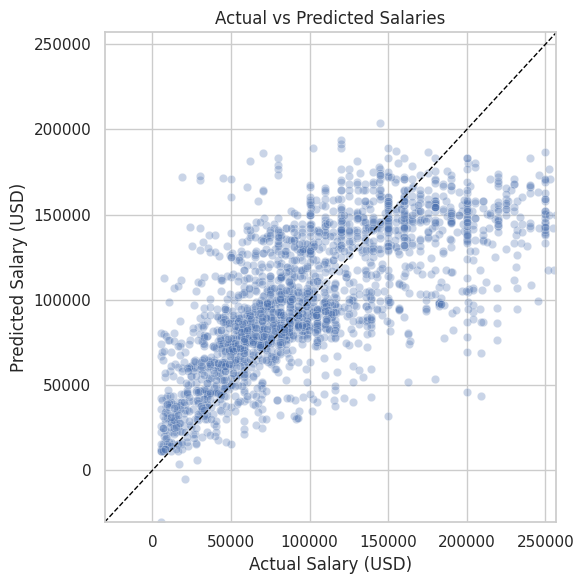

In [22]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=y_hat, alpha=0.3)
lims = [min(y_val.min(), y_hat.min()), max(y_val.max(), y_hat.max())]
plt.plot(lims, lims, "--", color="black", lw=1)
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.title("Actual vs Predicted Salaries")
plt.tight_layout()
plt.show()



*Further Analysis and Validation*


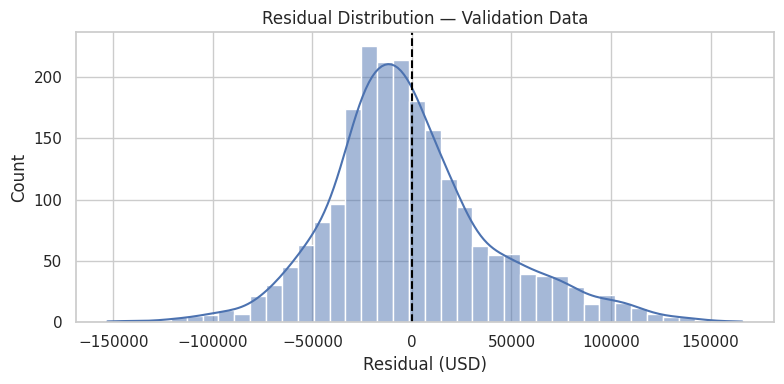

In [23]:
resid = y_val - y_hat

plt.figure(figsize=(8,4))
sns.histplot(resid, bins=40, kde=True)
plt.axvline(0, color="black", ls="--")
plt.xlabel("Residual (USD)")
plt.title("Residual Distribution — Validation Data")
plt.tight_layout()
plt.show()



*Most residuals cluster near zero, though a few extreme salaries cause a long tail, that would be typical for salary data with wide income ranges.*


**Analyze coefficients**

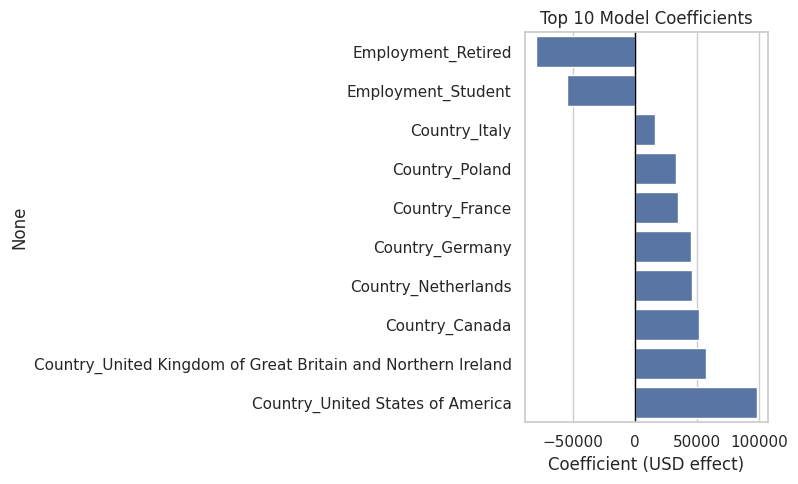

In [24]:
coef_series = pd.Series(lin.coef_, index=X.columns).sort_values(key=lambda s: s.abs(), ascending=False)
topn = 10
coef_top = coef_series.head(topn).sort_values()

plt.figure(figsize=(8,5))
sns.barplot(x=coef_top.values, y=coef_top.index)
plt.axvline(0, color="black", lw=1)
plt.xlabel("Coefficient (USD effect)")
plt.title(f"Top {topn} Model Coefficients")
plt.tight_layout()
plt.show()

**Experience (YearsCodePro) has the largest positive effect, meaning each extra year adds roughly a few thousand dollars on average. Some countries have positive coefficients (e.g., U.S. or Switzerland) — others slightly negative, reflecting real-world salary gaps.**

**Analyze possible effect of country on predicted salary**

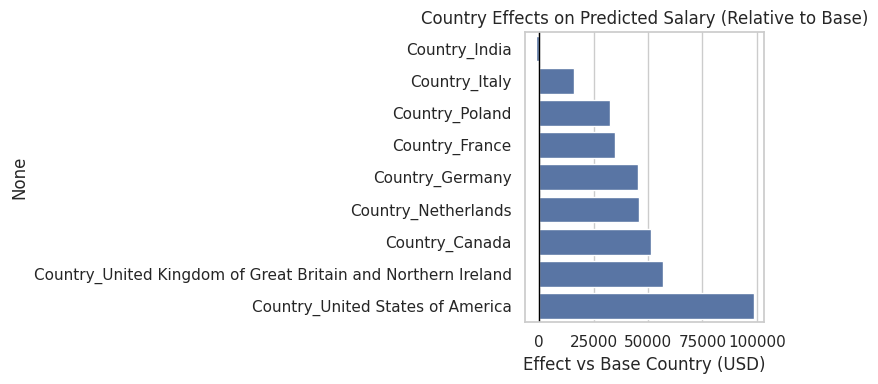

In [25]:
country_cols = [c for c in X.columns if c.startswith("Country_")]
country_coefs = coef_series.loc[country_cols].sort_values()

plt.figure(figsize=(8, max(4, 0.25*len(country_coefs))))
sns.barplot(x=country_coefs.values, y=country_coefs.index)
plt.axvline(0, color="black", lw=1)
plt.xlabel("Effect vs Base Country (USD)")
plt.title("Country Effects on Predicted Salary (Relative to Base)")
plt.tight_layout()
plt.show()


**Positive bars show countries with higher predicted salaries than the base (usually the first alphabetically, e.g., United Kingdom). Negative ones indicate slightly lower expected pay, even after adjusting for experience.**

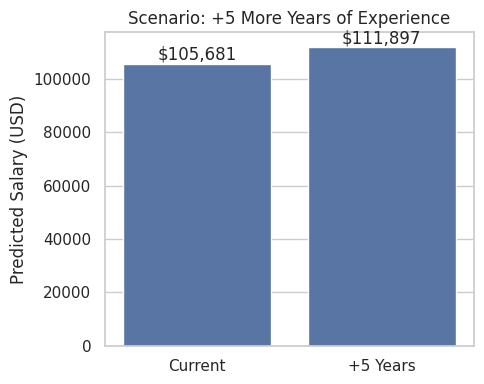

Predicted increase: +$6,216


In [26]:
x0 = X_val.sample(1, random_state=1)
base = lin.predict(x0)[0]

x0_plus5 = x0.copy()
if "YearsCodePro" in x0_plus5.columns:
    x0_plus5["YearsCodePro"] = x0_plus5["YearsCodePro"] + 5
alt = lin.predict(x0_plus5)[0]

plt.figure(figsize=(5,4))
sns.barplot(x=["Current", "+5 Years"], y=[base, alt])
plt.ylabel("Predicted Salary (USD)")
plt.title("Scenario: +5 More Years of Experience")
for i, v in enumerate([base, alt]):
    plt.text(i, v, f"${v:,.0f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

print(f"Predicted increase: +${alt - base:,.0f}")


**The predicted salary looks consistent with Q2’s trend**

### **Deployment/Communication**  

**Result and discussion are published in detail in:** https://github.com/tiguery/Data_Scientist_UdY/blob/main/README_1.md

**and a blog summary in** : https://medium.com/@claudeguery89/what-drives-developer-salary-and-job-satisfaction-around-the-world-0e5df33dfb9c